# YOLOv4 Object Detection on Webcam In Google Colab
This notebook will walkthrough all the steps for performing YOLOv4 object detections on your webcam while in Google Colab. We will be using scaled-YOLOv4 (yolov4-csp) for this tutorial, the fastest and most accurate object detector there currently is.

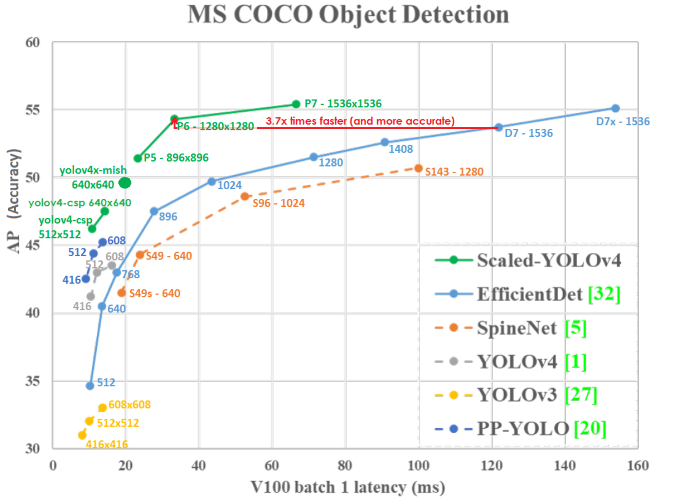

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 14748 (delta 2), reused 7 (delta 1), pack-reused 14736
Receiving objects: 100% (14748/14748), 13.28 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (10025/10025), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-04-01 07:49:04--  https://docs.google.com/uc?export=download&confirm=kfdW&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.20.138, 74.125.20.102, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/9f7t7f1vqclgn8mrl4dltk71cj1srkkq/55n78kt3dkk93efvfk1bu70trmj77si1/1617263325000/17800843676226924807/07562399647181974510Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-04-01 07:49:04--  https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/9f7t7f1vqclgn8mrl4dltk71cj1srkkq/55n78kt3dkk93efvfk1bu70trmj77si1/1617263325000/17800843676226924807/07562399647181974510Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-docs.googleusercontent.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting to 

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4(Custom and Web-Cam)

Below is a function to take the webcam picture using JavaScript or take custom input and then run YOLOv4 on it.

In [55]:
import itertools
from itertools import combinations
def is_close(p1, p2):
    """
    #================================================================
    # 1. Purpose : Calculate Euclidean Distance between two points
    #================================================================    
    :param:
    p1, p2 = two points for calculating Euclidean Distance

    :return:
    dst = Euclidean Distance between two 2d points
    """
    dst = math.sqrt(p1**2 + p2**2)
    #=================================================================#
    return dst 

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  #img = js_to_image(data) #Uncomment this if you want input from webcam
  img = cv2.imread('yolo.png') #Comment this if you want webcam input else use it as it is.
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)
  print(detections)

  centroid_dict = dict() 
  objectId = 0

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    if label == 'person':
      x,y,w,h=bbox[0],bbox[1],bbox[2],bbox[3]
      xmin, ymin, xmax, ymax = bbox2points(bbox)
      left, top, right, bottom = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
      centroid_dict[objectId] = (int(x), int(y), xmin, ymin, xmax, ymax,h)
      objectId += 1
      #cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
      '''cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)'''
  print(centroid_dict.items())
  red_zone_list = [] # List containing which Object id is in under threshold distance condition. 
  red_line_list = []
  for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2): # Get all the combinations of close detections, #List of multiple items - id1 1, points 2, 1,3
      dx, dy = p1[0] - p2[0], p1[1] - p2[1]
      dh1,dh2 = p1[6],p2[6]  	# Check the difference between centroid x: 0, y :1
      distance = is_close(dx, dy)
      print(distance) 			# Calculates the Euclidean distance
      if abs(dh1-dh2) < 50.0:
        hc=(dh1+dh2)/2
        print("hc",hc)
        dc = (hc/348)*245
        print("dc",dc)
        if distance<dc:						# Set our social distance threshold - If they meet this condition then..
          if id1 not in red_zone_list:
              red_zone_list.append(id1)       #  Add Id to a list
              red_line_list.append(p1[0:2])   #  Add points to the list
          if id2 not in red_zone_list:
              red_zone_list.append(id2)		# Same for the second id 
              red_line_list.append(p2[0:2])
  print(red_zone_list)

  for idx, box in centroid_dict.items():
    xmin, ymin, xmax, ymax = box[2],box[3],box[4],box[5]
    left, top, right, bottom = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)  # dict (1(key):red(value), 2 blue)  idx - key  box - value
    if idx in red_zone_list:
      cv2.rectangle(img, (left, top), (right, bottom), (0,0,255), 2)
    else:
      cv2.rectangle(img, (left, top), (right, bottom), (0,255,0), 2)
  '''for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
    xl1,yl1,xl2,yl2 = p1[0],p1[1],p2[0],p2[1]
    if id1 in red_zone_list and id2 in red_zone_list:
      cv2.line(img, (xl1,yl1), (xl2,yl2), (255, 0, 0), 2)'''
  text = "People at Risk: %s" % str(len(red_zone_list)) 			# Count People at Risk
  location = (10,25)												# Set the location of the displayed text
  cv2.putText(img, text, location, cv2.FONT_HERSHEY_SIMPLEX, 1, (246,86,86), 2, cv2.LINE_AA)  # Display Text

  # save image
  cv2.imwrite(filename, img)
  print(centroid_dict[0])

  return filename

<IPython.core.display.Javascript object>

[('person', '50.43', (302.51715087890625, 278.41064453125, 27.939537048339844, 152.71139526367188)), ('person', '68.95', (151.627685546875, 277.4090576171875, 26.025882720947266, 143.969970703125)), ('person', '74.84', (404.2720947265625, 279.9271240234375, 50.892425537109375, 208.69007873535156)), ('person', '78.78', (274.88287353515625, 286.6019287109375, 55.07258987426758, 227.78961181640625)), ('person', '81.32', (455.8857116699219, 256.90362548828125, 112.01342010498047, 510.8674621582031)), ('person', '85.25', (79.95750427246094, 283.38568115234375, 34.84521484375, 169.9668731689453)), ('person', '86.05', (212.8246307373047, 285.1023864746094, 32.858367919921875, 182.6107177734375)), ('person', '87.58', (117.61322784423828, 280.98345947265625, 41.8553466796875, 173.01524353027344)), ('person', '88.62', (46.033119201660156, 281.82012939453125, 36.43580627441406, 170.82147216796875)), ('person', '88.75', (179.01222229003906, 282.0575866699219, 39.11860656738281, 197.57382202148438)

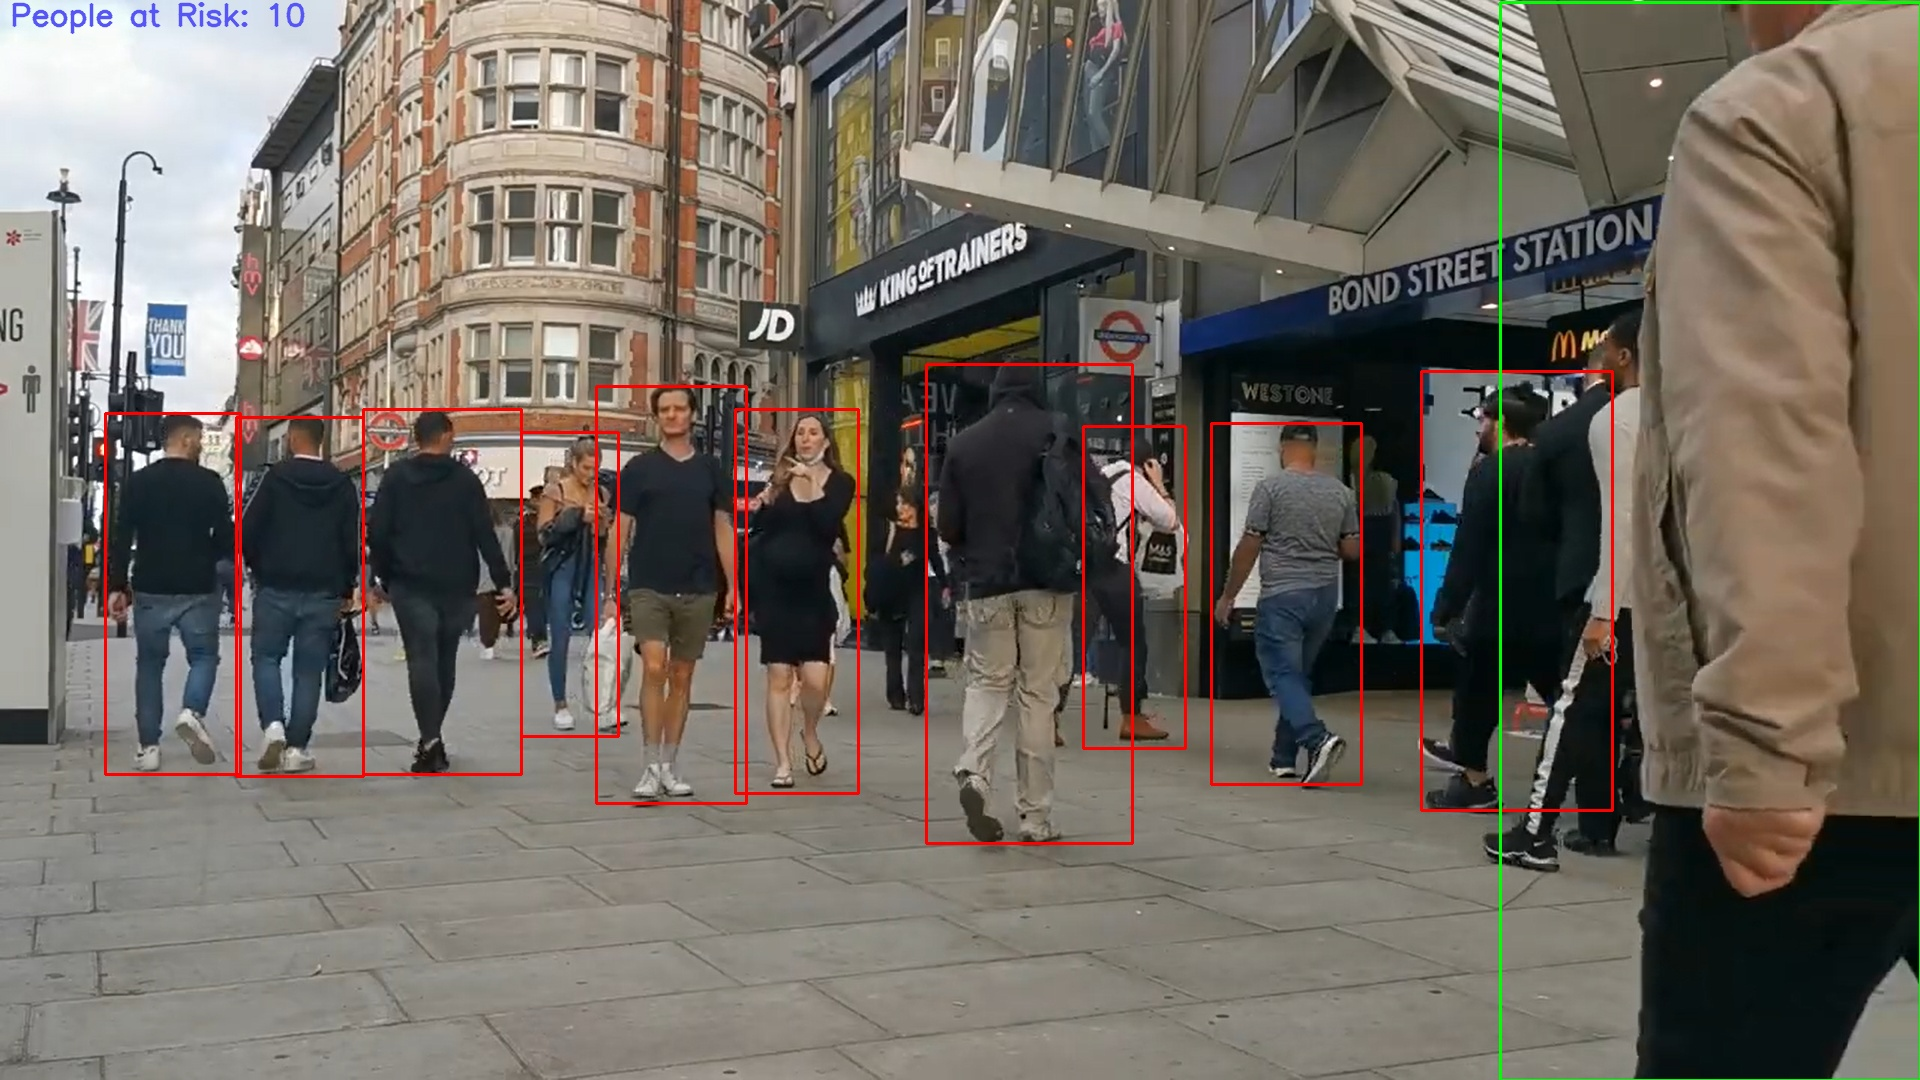

In [56]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Thankyou!!


